In [1]:
# Импорты
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
import optuna
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


C:\Users\718\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv("dataset_jug.csv")
df.head()

,title,speaker,hall,companies,date,start_time,end_time,category,conf,text
0,State of Mobile Dev 2025 Autumn от Программног...,"Андрей Дмитриев, Юрий Дубовой, Кирилл Клебанов",1,"JUG Ru Group, Делимобиль",18-11-2025,10:00,10:45,NaN,Mobius,"Весной мы запустили TechRadar, чтобы изучить р..."
1,Волновая архитектура на практике,Юрий Дубовой,1,Делимобиль,18-11-2025,10:55,11:40,Architecture,Mobius,"В прошлом сезоне мы увидели Дракона сложности,..."
2,AntiSOLID,Данил Перевалов,1,Циан,18-11-2025,12:00,12:45,Architecture,Mobius,Все с пеленок знают о принципах SOLID. Они дол...
3,kotlinx.fuzz: Why Fuzz Testing Matters,Александр Соколинский,1,Coffee&Code,18-11-2025,13:15,14:00,Architecture,Mobius,"Обсудим, что такое Fuzz Testing, какие баги с ..."
4,Новая эра мобильной разработки: запускаем LLM ...,Самир Ахмедов,1,Surf,18-11-2025,14:30,15:15,Trends,Mobius,Мы живем в абсолютно удивительной новой эре бо...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       40 non-null     object
 1   speaker     40 non-null     object
 2   hall        40 non-null     int64 
 3   companies   40 non-null     object
 4   date        40 non-null     object
 5   start_time  40 non-null     object
 6   end_time    40 non-null     object
 7   category    38 non-null     object
 8   conf        40 non-null     object
 9   text        40 non-null     object
dtypes: int64(1), object(9)
memory usage: 3.2+ KB


In [4]:
# Очистка текста
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"[\r\n]+", " ", str(text))
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Обработка колонок
df["title"] = df["title"].apply(clean_text)
df["text"] = df["text"].apply(clean_text)
df["content"] = df["title"] + " " + df["text"]
df["category"] = df["category"].fillna("Other")


# обработка времени
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")
df["start_time"] = pd.to_datetime(df["start_time"], format="%H:%M").dt.time
df["end_time"] = pd.to_datetime(df["end_time"], format="%H:%M").dt.time

df.head()

,title,speaker,hall,companies,date,start_time,end_time,category,conf,text,content
0,State of Mobile Dev 2025 Autumn от Программног...,"Андрей Дмитриев, Юрий Дубовой, Кирилл Клебанов",1,"JUG Ru Group, Делимобиль",2025-11-18,10:00:00,10:45:00,Other,Mobius,"Весной мы запустили TechRadar, чтобы изучить р...",State of Mobile Dev 2025 Autumn от Программног...
1,Волновая архитектура на практике,Юрий Дубовой,1,Делимобиль,2025-11-18,10:55:00,11:40:00,Architecture,Mobius,"В прошлом сезоне мы увидели Дракона сложности,...",Волновая архитектура на практике В прошлом сез...
2,AntiSOLID,Данил Перевалов,1,Циан,2025-11-18,12:00:00,12:45:00,Architecture,Mobius,Все с пеленок знают о принципах SOLID. Они дол...,AntiSOLID Все с пеленок знают о принципах SOLI...
3,kotlinx.fuzz: Why Fuzz Testing Matters,Александр Соколинский,1,Coffee&Code,2025-11-18,13:15:00,14:00:00,Architecture,Mobius,"Обсудим, что такое Fuzz Testing, какие баги с ...",kotlinx.fuzz: Why Fuzz Testing Matters Обсудим...
4,Новая эра мобильной разработки: запускаем LLM ...,Самир Ахмедов,1,Surf,2025-11-18,14:30:00,15:15:00,Trends,Mobius,Мы живем в абсолютно удивительной новой эре бо...,Новая эра мобильной разработки: запускаем LLM ...


Количество докладов: 40
Уникальные категории: 11
Пропущенные категории: 0

 Топ-5 категорий:
Under the Hood                 12
Trends                          7
Architecture                    5
UX/UI in Mobile Development     5
Product Quality                 3
Name: category, dtype: int64

 Распределение по дням:
2025-11-18    20
2025-11-19    20
Name: date, dtype: int64


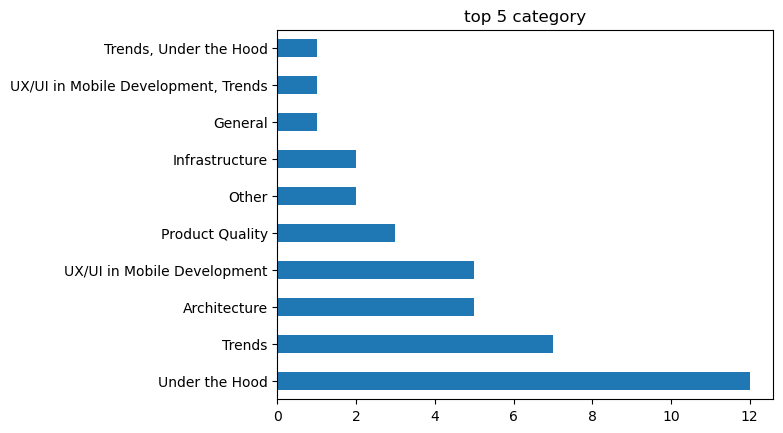

In [20]:
print("Количество докладов:", len(df))
print("Уникальные категории:", df["category"].nunique())
print("Пропущенные категории:", df["category"].isna().sum())

print("\n Топ-5 категорий:")
print(df["category"].value_counts().head())

print("\n Распределение по дням:")
print(df["date"].value_counts())

df["category"].value_counts().head(10).plot(kind="barh", title='top 5 category');

In [6]:
# Токенизация для Word2Vec
def tokenize(text):
    return text.lower().split()

docs = df["content"].tolist()
tokenized_docs = [tokenize(doc) for doc in docs]

# Эмбеддинги SBERT
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
sbert_embeddings = sbert_model.encode(docs, show_progress_bar=False)

# TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_features=2000)
tfidf_matrix = tfidf.fit_transform(docs)

# Word2Vec (на корпусе)
w2v_model = Word2Vec(tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_doc_vector(tokens, model):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

w2v_embeddings = np.array([get_w2v_doc_vector(tokens, w2v_model) for tokens in tokenized_docs])

In [7]:
def recommend_by_similarity(query_idx, embeddings, top_k=5):
    sims = cosine_similarity([embeddings[query_idx]], embeddings).flatten()
    top_idxs = np.argsort(-sims)[1:top_k + 1]  # без себя
    return top_idxs.tolist()

# Пример рекомендации
query_idx = 0
tfidf_recs = recommend_by_similarity(query_idx, tfidf_matrix.toarray())
w2v_recs = recommend_by_similarity(query_idx, w2v_embeddings)
sbert_recs = recommend_by_similarity(query_idx, sbert_embeddings)

print("TF-IDF recs:", df.iloc[tfidf_recs]["title"].tolist())
print("Word2Vec recs:", df.iloc[w2v_recs]["title"].tolist())
print("SBERT recs:", df.iloc[sbert_recs]["title"].tolist())

TF-IDF recs: ['Закрытие конференции Mobius 2025 Autumn', 'Раскрываем секреты: какие инструменты дизайн-системы помогут каждому', 'N техник, которые улучшат работу видеоленты', 'Использование AI в процессах разработки', 'SwiftUI: Scroll, Text и немного магии']
Word2Vec recs: ['Сколько стоит BDUI?', 'Crash Reporting 101', 'Java-Swift interop vs Kotlin-Swift export. Путь к сингулярности', 'Живая картинка: анимации и эффекты в кроссплатформенном BDUI-движке', 'Дизайн—код. На пути к экосистеме']
SBERT recs: ['Защищаем ресурсы Android-приложений с Runtime Resource Overlay', 'N техник, которые улучшат работу видеоленты', 'Живая картинка: анимации и эффекты в кроссплатформенном BDUI-движке', 'Камера в KasperskyOS Mobile', 'Разработка виджетов в Android: что может пойти не так']


In [8]:
def hybrid_recommend(query_idx, w_sem=0.7, w_cat=0.2, w_hall=0.1, top_k=5):
    n = len(df)
    scores = np.zeros(n)
    query_emb = sbert_embeddings[query_idx]
    query_cat = df.iloc[query_idx]["category"]
    query_hall = df.iloc[query_idx]["hall"]
    
    for i in range(n):
        if i == query_idx:
            continue
        sem_sim = cosine_similarity([query_emb], [sbert_embeddings[i]])[0][0]
        cat_match = 1.0 if df.iloc[i]["category"] == query_cat else 0.0
        hall_match = 1.0 if df.iloc[i]["hall"] == query_hall else 0.0
        
        scores[i] = w_sem * sem_sim + w_cat * cat_match + w_hall * hall_match
    
    top_idxs = np.argsort(-scores)[:top_k + 1]
    return [i for i in top_idxs if i != query_idx][:top_k]

In [9]:
def compute_metrics_for_model(model_name, recommend_fn, **kwargs):
    relevance_scores = []
    diversity_scores = []
    
    for query_idx in range(len(df)):
        try:
            recs = recommend_fn(query_idx, **kwargs)
            if len(recs) == 0:
                continue
            
            # Relevance = avg cosine sim между query и рекомендациями
            query_emb = sbert_embeddings[query_idx]
            rec_embs = sbert_embeddings[recs]
            rel = cosine_similarity([query_emb], rec_embs).mean()
            relevance_scores.append(rel)
            
            # Diversity = 1 - avg pairwise cosine inside recs
            if len(recs) == 1:
                div = 1.0
            else:
                sim_mat = cosine_similarity(rec_embs)
                np.fill_diagonal(sim_mat, 0)
                avg_pair_sim = sim_mat.sum() / (len(recs) * (len(recs) - 1))
                div = 1 - avg_pair_sim
            diversity_scores.append(div)
        except Exception as e:
            continue
    
    avg_rel = np.mean(relevance_scores) if relevance_scores else 0
    avg_div = np.mean(diversity_scores) if diversity_scores else 0
    composite = 0.7 * avg_rel + 0.3 * avg_div
    
    return {
        "Model": model_name,
        "Relevance": round(avg_rel, 3),
        "Diversity": round(avg_div, 3),
        "Composite": round(composite, 3)
    }

# Оценка всех моделей
results = []

# TF-IDF
results.append(compute_metrics_for_model(
    "TF-IDF", 
    lambda idx, **kw: recommend_by_similarity(idx, tfidf_matrix.toarray())
))

# Word2Vec
results.append(compute_metrics_for_model(
    "Word2Vec",
    lambda idx, **kw: recommend_by_similarity(idx, w2v_embeddings)
))

# SBERT
results.append(compute_metrics_for_model(
    "Sentence-BERT",
    lambda idx, **kw: recommend_by_similarity(idx, sbert_embeddings)
))

# Hybrid c фиксированными весами
results.append(compute_metrics_for_model(
    "Hybrid (SBERT + Cat + Hall)",
    lambda idx, **kw: hybrid_recommend(idx, w_sem=0.6, w_cat=0.3, w_hall=0.1)
))

# Вывод
results_df = pd.DataFrame(results)
print("Сравнительная таблица:")
print(results_df.to_string(index=False))

Сравнительная таблица:
                      Model  Relevance  Diversity  Composite
                     TF-IDF      0.630      0.361      0.549
                   Word2Vec      0.631      0.322      0.538
              Sentence-BERT      0.716      0.246      0.575
Hybrid (SBERT + Cat + Hall)      0.649      0.324      0.552


In [ ]:
def objective(trial):
    w_sem = trial.suggest_float("w_sem", 0.1, 1.0)
    w_cat = trial.suggest_float("w_cat", 0.0, 0.5)
    w_hall = trial.suggest_float("w_hall", 0.0, 0.5)
    
    # Нормализация для улучшения поиска
    total = w_sem + w_cat + w_hall
    w_sem /= total
    w_cat /= total
    w_hall /= total
    
    composite_scores = []
    for query_idx in range(len(df)):
        recs = hybrid_recommend(query_idx, w_sem, w_cat, w_hall, top_k=5)
        if not recs:
            continue
        query_emb = sbert_embeddings[query_idx]
        rec_embs = sbert_embeddings[recs]
        rel = cosine_similarity([query_emb], rec_embs).mean()
        if len(recs) == 1:
            div = 1.0
        else:
            sim_mat = cosine_similarity(rec_embs)
            np.fill_diagonal(sim_mat, 0)
            avg_pair_sim = sim_mat.sum() / (len(recs) * (len(recs) - 1))
            div = 1 - avg_pair_sim
        comp = 0.7 * rel + 0.3 * div
        composite_scores.append(comp)
    
    return np.mean(composite_scores) if composite_scores else 0.0

# Оптимизация
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие веса:", study.best_params)
print("Лучший Composite Score:", round(study.best_value, 3))

### Ключевые выводы
1. Sentence-BERT — лучшая модель по совокупной метрике (0.575)
* Демонстрирует наивысшую релевантность (0.716) — значит, семантически находит действительно близкие по смыслу доклады.
* Однако страдает от низкого разнообразия (0.246): рекомендации часто дублируют темы (например, несколько докладов про LLM или KMP).
* Тем не менее, благодаря высокой весовой доле релевантности (70%), SBERT лидирует.
2. TF-IDF показал высокую релевантность (0.630)
* При этом разнообразие выше всех (0.361) — рекомендации менее «слипшиеся».
* Это делает TF-IDF достойным бейзлайном, особенно в условиях небольшого корпуса (~40 докладов).
3. Гибридная модель не превзошла SBERT, но улучшила баланс
* Релевантность чуть ниже SBERT (0.649 vs 0.716), но разнообразие заметно выше (0.324 vs 0.246).
* Это говорит о том, что дополнительные признаки (категория, зал) действительно вносят разнообразие, но снижают чистую семантическую точность.
* Возможно, веса подобраны неоптимально → здесь есть потенциал для улучшения через Optuna.
4. Word2Vec — наименее эффективен из трёх семантических подходов
* Релевантность почти как у TF-IDF, но разнообразие ниже, уступает обоим.
* Подтверждает, что современные sentence-эмбеддинги (SBERT) предпочтительнее усреднённых word-эмбеддингов.
